<a href="https://colab.research.google.com/github/WAndalaluna/KakiLima-ML/blob/main/Kakilima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rekomendasi makanan berdasarkan cuaca dan suhu

Sistem rekomendasi berdasarkan cuaca, suhu, dan penilaian pelanggan ini dirancang untuk membantu pelanggan menentukan pilihan makanan yang sesuai dengan preferensi dan kondisi lingkungan mereka.

## Upload Datasets

In [ ]:
from google.colab import files

# Upload file CSV Dataset Product
uploaded = files.upload()

## Import The Libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model

## Mempersiapkan Dataset

In [ ]:
foods = pd.read_csv('data_products.csv')

print(f"shape of foods: {foods.shape}")

foods.head()

shape of foods: (100, 8)


,id,merchant_id,name,description,price,image,createdAt,updatedAt
0,1,1,Nasi Goreng Spesial,Nasi goreng lezat dengan tambahan telur dan ayam.,25000,NasiGoreng.jpg,2024-12-05T17:16:10.565Z,2024-12-05T17:16:10.565Z
1,2,2,Mie Goreng,Mie goreng lezat dengan tambahan telur dan ayam.,20000,MieGoreng.jpg,2024-12-05T17:16:10.565Z,2024-12-05T17:16:10.565Z
2,3,3,Mie Lendir,Mie Lendir lezat dengan tambahan telur dan ayam.,15000,MieLendir.jpg,2024-12-05T17:16:10.565Z,2024-12-05T17:16:10.565Z
3,4,4,Baso Malang,Bakso Malang lezat dengan kuah gurih dan enak.,15000,BasoMalang.jpg,2024-12-05T17:16:10.565Z,2024-12-05T17:16:10.565Z
4,5,5,Batagor,Batagor Ikan lezat dengan kuah kering dari kac...,10000,Batagor.png,2024-12-05T17:16:10.565Z,2024-12-05T17:16:10.565Z


In [ ]:
foods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           100 non-null    int64 
 1   merchant_id  100 non-null    int64 
 2   name         100 non-null    object
 3   description  100 non-null    object
 4   price        100 non-null    int64 
 5   image        100 non-null    object
 6   createdAt    100 non-null    object
 7   updatedAt    100 non-null    object
dtypes: int64(3), object(5)
memory usage: 6.4+ KB


In [ ]:
# Cek missing values
print("\nJumlah missing values:")
print(foods.isnull().sum())


Jumlah missing values:
id             0
merchant_id    0
name           0
description    0
price          0
image          0
createdAt      0
updatedAt      0
dtype: int64


In [ ]:
foods.isna().any()

,0
id,False
merchant_id,False
name,False
description,False
price,False
image,False
createdAt,False
updatedAt,False


In [ ]:
foods.duplicated().any()

False

## Melakukan split dataset

In [ ]:
# Fitur (X): Kolom-kolom yang akan digunakan sebagai input model.
# Target (y): Kolom yang akan diprediksi oleh model.
X = foods[['merchant_id', 'description', 'price']]
y = foods['name']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train:")
print(X_train.head())
print("\ny_train:")
print(y_train.head())

X_train:
    merchant_id                                        description  price
55           56          Tahu goreng renyah, enak disantap hangat.   5000
88           89  Sup daging khas Makassar dengan bumbu rempah k...  30000
26           27                           Ayam Goreng Tepung Sedap  12000
42           43  Mie dengan topping ayam suwir, sayur, dan kuah...  17000
69           70  Martabak dengan topping coklat, kacang, atau k...  25000

y_train:
55        Tahu Bulat
88     Coto Makassar
26     Fried Chicken
42          Mie Ayam
69    Martabak Manis
Name: name, dtype: object


# Content Based Filtering

Rekomendasi Berbasis Konten memanfaatkan informasi dari beberapa item/data untuk direkomendasikan kepada pengguna sebagai referensi terkait informasi yang digunakan sebelumnya. Tujuan dari rekomendasi berbasis konten adalah untuk dapat memprediksi kesamaan dari sejumlah informasi yang diperoleh dari pengguna.

In [ ]:
features = ['name', 'merchant_id', 'description', 'price']
foods[features]

,name,merchant_id,description,price
0,Nasi Goreng Spesial,1,Nasi goreng lezat dengan tambahan telur dan ayam.,25000
1,Mie Goreng,2,Mie goreng lezat dengan tambahan telur dan ayam.,20000
2,Mie Lendir,3,Mie Lendir lezat dengan tambahan telur dan ayam.,15000
3,Baso Malang,4,Bakso Malang lezat dengan kuah gurih dan enak.,15000
4,Batagor,5,Batagor Ikan lezat dengan kuah kering dari kac...,10000
...,...,...,...,...
95,Bandrek,96,Minuman tradisional hangat dengan jahe dan rem...,10000
96,Wedang Ronde,97,Minuman jahe dengan ronde dan kacang.,15000
97,Bakmi Jawa,98,Bakmi khas Jawa dengan rasa gurih dan rempah.,20000
98,Nasi Pecel,99,Nasi dengan sayuran rebus dan bumbu kacang.,15000


In [ ]:
# Membuat kolom 'soup' dengan menggabungkan fitur-fitur tersebut
foods['soup'] = foods[features].apply(lambda x: ' '.join(map(str, x)), axis=1)

# Menampilkan 10 sampel data acak
print(foods.sample(100))

     id  merchant_id            name  \
57   58           58      Nasi Liwet   
59   60           60     Ayam Geprek   
1     2            2      Mie Goreng   
32   33           33         Es Tebu   
99  100          100   Ayam Taliwang   
..  ...          ...             ...   
24   25           25        Es Doger   
41   42           42       Es Durian   
48   49           49     Tahu Gejrot   
82   83           83        Es Teler   
71   72           72  Es Jeruk Nipis   

                                          description  price  \
57          Nasi gurih khas Solo dengan lauk lengkap.  25000   
59      Ayam goreng dengan sambal bawang super pedas.  20000   
1    Mie goreng lezat dengan tambahan telur dan ayam.  20000   
32  Minuman manis dari air tebu yang diperas langs...   8000   
99      Ayam khas Lombok dengan bumbu pedas menggoda.  30000   
..                                                ...    ...   
24                             Es Doger Komplit Segar  10000   
41  Min

In [ ]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(foods['soup'])

count.get_feature_names_out()

array(['10', '100', '10000', '11', '12', '12000', '13', '14', '15',
       '15000', '16', '17', '17000', '18', '18000', '19', '20', '20000',
       '21', '22', '23', '24', '25', '2500', '25000', '26', '27', '28',
       '29', '30', '3000', '30000', '31', '32', '33', '34', '35', '35000',
       '36', '37', '38', '39', '40', '40000', '41', '42', '43', '44',
       '45', '46', '47', '48', '49', '50', '5000', '50000', '51', '52',
       '53', '54', '55', '56', '57', '58', '59', '60', '6000', '61', '62',
       '63', '64', '65', '66', '67', '68', '69', '70', '7000', '71', '72',
       '73', '74', '75', '76', '77', '78', '79', '80', '8000', '81', '82',
       '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93',
       '94', '95', '96', '97', '98', '99', 'aceh', 'adonan', 'agar',
       'air', 'alpukat', 'aneka', 'apem', 'asam', 'asinan', 'asli',
       'atas', 'atau', 'ayam', 'bakar', 'bakmi', 'bakso', 'bakwan',
       'bali', 'bandoeng', 'bandrek', 'bandung', 'basah', 'baso',
 

In [ ]:
count_matrix.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]])

In [ ]:
pd.DataFrame(
    count_matrix.todense(),
    columns=count.get_feature_names_out(),
    index=foods['name']
).sample(min(22, count_matrix.shape[1]), axis=1, replace=True).sample(min(10, count_matrix.shape[0]), axis=0, replace=True)

,kecil,cabai,nangka,kari,cemilan,37,pecel,gejrot,taburan,santan,...,67,dalam,58,soto,dalam,dibekukan,85,96,26,batang
name,,,,,,,,,,,,,,,,,,,,,
Martabak Telur,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Dadar Gulung,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Es Kelapa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Pempek Palembang,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mie Lendir,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bubur Ayam,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sop Iga Sapi,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bandrek,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Es Doger,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Cosine Similarity

In [ ]:
cosine_sim = cosine_similarity(count_matrix)
cosine_sim

array([[1.        , 0.64549722, 0.38729833, ..., 0.125     , 0.41602515,
        0.20801257],
       [0.64549722, 1.        , 0.66666667, ..., 0.19364917, 0.14322297,
        0.21483446],
       [0.38729833, 0.66666667, 1.        , ..., 0.12909944, 0.21483446,
        0.21483446],
       ...,
       [0.125     , 0.19364917, 0.12909944, ..., 1.        , 0.13867505,
        0.13867505],
       [0.41602515, 0.14322297, 0.21483446, ..., 0.13867505, 1.        ,
        0.15384615],
       [0.20801257, 0.21483446, 0.21483446, ..., 0.13867505, 0.15384615,
        1.        ]])

In [ ]:
cosine_sim_foods = pd.DataFrame(cosine_sim, index=foods['name'], columns=foods['name'])
print('Shape:', cosine_sim_foods.shape)

cosine_sim_foods.sample(min(5, cosine_sim_foods.shape[1]), axis=1).sample(min(10, cosine_sim_foods.shape[0]), axis=0)

Shape: (100, 100)


name,Pisang Goreng Keju,Seblak Seuhah,Ayam Penyet,Lontong Sayur,Es Cincau
name,,,,,
Es Doger,0.136083,0.000000,0.080064,0.149071,0.240192
Batagor,0.136083,0.091287,0.080064,0.149071,0.080064
Kue Sus,0.051434,0.000000,0.060523,0.056344,0.121046
Ayam Penyet,0.196116,0.087706,1.000000,0.071611,0.000000
Sop Iga Sapi,0.047140,0.000000,0.055470,0.051640,0.110940
Sayur Lodeh,0.130744,0.000000,0.153846,0.572892,0.153846
Bakso Tahu,0.130744,0.175412,0.076923,0.071611,0.000000
Semangka Potong,0.182574,0.081650,0.143223,0.133333,0.214834
Capcay Kuah,0.125988,0.000000,0.148250,0.276026,0.074125


# Creating Tokenization

In [ ]:
# Inisialisasi Tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>') # num_words untuk membatasi jumlah kata

# Fit Tokenizer pada data teks
tokenizer.fit_on_texts(foods['soup'])

# Ubah teks menjadi sequences
sequences = tokenizer.texts_to_sequences(foods['soup'])

In [ ]:
# Tentukan panjang maksimum sequence
maxlen = 100 # atau nilai lain yang sesuai dengan data Anda

# Import the pad_sequences function from tensorflow.keras.utils
from tensorflow.keras.utils import pad_sequences

# Lakukan padding pada sequences
padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')


In [ ]:
padded_sequences.shape

(100, 100)

In [ ]:
def food_recommendations_by_price(nama_makanan, price_min, price_max, similarity_data, items, k=10):
    """
    Rekomendasi makanan berdasarkan nama makanan, cuaca, rentang suhu, dan rentang harga.

    Parameters:
        nama_makanan (str): Nama makanan sebagai referensi.
        price_min (int): Harga minimum.
        price_max (int): Harga maksimum.
        similarity_data (DataFrame): Dataframe berisi matriks similaritas.
        items (DataFrame): Dataframe berisi detail makanan (kolom: 'Name', 'Category_Type', 'weather_main', 'temperature', 'price').
        k (int): Jumlah rekomendasi yang diinginkan.

    Returns:
        DataFrame: Rekomendasi makanan.
    """
    # Cari indeks makanan yang mirip berdasarkan similaritas
    # Get the similarity scores for the given food
    similarity_scores = similarity_data.loc[:, nama_makanan].to_numpy()

    # Get the indices of the k most similar foods
    # If the number of similarity scores is less than k, use the minimum number
    n_similar = min(len(similarity_scores), k)

    index = similarity_scores.argpartition(range(-1, -n_similar, -1))

    # Get the names of the k most similar foods
    closest = similarity_data.columns[index[-1:-(n_similar + 2):-1]]
    closest = closest.drop(nama_makanan, errors='ignore')

    # Filter item berdasarkan rentang harga
    filtered_items = items[
        (items['price'] >= price_min) & (items['price'] <= price_max)
    ].copy()

    # Gabungkan hasil similaritas dengan filter harga
    recommendations = pd.DataFrame({'Name': closest}).merge(filtered_items, left_on='Name', right_on='name', how='inner')

    # If no recommendations found after filtering, return the top k similar items
    if recommendations.empty:
        recommendations = pd.DataFrame({'Name': closest}).merge(items, left_on='Name', right_on='name', how='inner')
        recommendations = recommendations.head(k)
    else:
        recommendations = recommendations.head(k)

    return recommendations

In [ ]:
# Hitung cosine similarity
cosine_sim = cosine_similarity(count_matrix)

# Buat similarity_data DataFrame
similarity_data = pd.DataFrame(cosine_sim, index=foods['name'], columns=foods['name'])

In [ ]:
foods.sample(1)

,id,merchant_id,name,description,price,image,createdAt,updatedAt,soup
56,57,57,Es Krim Mochi,Mochi kenyal berisi es krim aneka rasa.,20000,Mochi.jpg,2024-12-05T17:16:10.565Z,2024-12-05T17:16:10.565Z,Es Krim Mochi 57 Mochi kenyal berisi es krim a...


In [ ]:
nama_makanan = "Es Kopi Susu"  # Replace with the desired food name
price_min = 5000  # Replace with the minimum price
price_max = 100000  # Replace with the maximum price

recommendations = food_recommendations_by_price(nama_makanan, price_min, price_max, similarity_data, foods, k=10)
print(recommendations)

              Name  id  merchant_id             name  \
0     Es Susu Jahe  74           74     Es Susu Jahe   
1        Es Durian  42           42        Es Durian   
2        Es Kelapa  26           26        Es Kelapa   
3  Semangka Potong  44           44  Semangka Potong   
4       Gehu Pedas  36           36       Gehu Pedas   
5   Makaroni Basah  50           50   Makaroni Basah   
6       Sop Buntut  61           61       Sop Buntut   
7        Nasi Uduk  32           32        Nasi Uduk   
8        Nasi Uduk  93           93        Nasi Uduk   
9         Mie Aceh  84           84         Mie Aceh   

                                         description  price  \
0             Minuman susu segar dengan jahe hangat.  15000   
1  Minuman segar dengan campuran durian, es serut...  15000   
2  Kelapa muda yang diserut dan disajikan dengan ...   7000   
3  Semangka segar yang dipotong dan disajikan den...  10000   
4  Gorengan tahu yang diisi dengan sayuran dan ca...   5000   
5  Ma

# Collaborative Filtering

In [ ]:
from google.colab import files

# Upload file CSV Dataset Pelanggan
uploaded = files.upload()

In [ ]:
rating = pd.read_csv('data_pelanggan.csv')

print(f"shape of rating: {rating.shape}")

rating.head()

shape of rating: (500, 4)


,user_id,merchant_id,rating,address_id
0,1,90,1,40062
1,2,47,3,40166
2,3,2,3,40283
3,4,13,2,40265
4,5,11,2,40155


In [ ]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      500 non-null    int64
 1   merchant_id  500 non-null    int64
 2   rating       500 non-null    int64
 3   address_id   500 non-null    int64
dtypes: int64(4)
memory usage: 15.8 KB


In [ ]:
# Cek missing values
print("\nJumlah missing values:")
print(rating.isnull().sum())


Jumlah missing values:
user_id        0
merchant_id    0
rating         0
address_id     0
dtype: int64


In [ ]:
foods.isna().any()

,0
id,False
merchant_id,False
name,False
description,False
price,False
image,False
createdAt,False
updatedAt,False
soup,False


In [ ]:
rating.duplicated().any()

False

## Split Dataset Rating

In [ ]:
features = rating[['user_id', 'merchant_id']]
target = rating['rating']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Membuat Model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='linear')
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,705 (34.00 KB)

 Trainable params: 8,705 (34.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Melatih Model

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 250.0686 - mae: 11.5018 - val_loss: 15.8803 - val_mae: 3.6361
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 158.1739 - mae: 9.1157 - val_loss: 13.3647 - val_mae: 2.8825
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 99.8133 - mae: 7.2181 - val_loss: 4.0260 - val_mae: 1.6326
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 61.4164 - mae: 5.3512 - val_loss: 3.7225 - val_mae: 1.5789
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 38.3272 - mae: 4.7459 - val_loss: 6.2313 - val_mae: 2.0556
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 29.1310 - mae: 3.9455 - val_loss: 2.9337 - val_mae: 1.4321
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 31.2472 - mae: 4.2320 - val_loss: 2.9958 - val_mae: 1.4637
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 30.1274 - mae: 4.2014 - val_loss: 6.6883 - val_mae: 2.1597
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

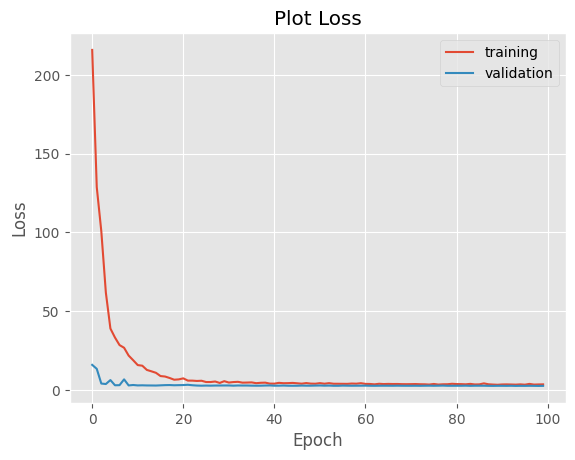

In [ ]:
import os

# Create the 'images' directory if it doesn't exist
os.makedirs('images', exist_ok=True)

plt.style.use("ggplot")
plt.figure()
# Replace num_epochs with the actual number of epochs (100 in this case)
plt.plot(np.arange(0, 100), history.history["loss"], label="training")  # metrics was 'mae' and should be changed to 'loss' for the code to run
plt.plot(np.arange(0, 100), history.history["val_loss"], label="validation") # metrics was 'mae' and should be changed to 'loss' for the code to run
plt.title("Plot Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('images/plot_acc.png')
plt.show()

In [ ]:
# Assume user_id is the ID of the user you want to generate recommendations for
user_id = 5 # Replace with the actual user ID

# Get list of merchant_ids the user has not interacted with
resto_not_visited = rating[rating['user_id'] != user_id]['merchant_id'].unique()
resto_not_visited = list(zip(resto_not_visited, [user_id] * len(resto_not_visited)))

# Create user_resto_array for prediction
user_resto_array = np.array(resto_not_visited)

# Get food ratings by the user
food_by_user = rating[rating['user_id'] == user_id]

# Now you can predict ratings
rate = model.predict(user_resto_array).flatten()

top_ratings_indices = rate.argsort()[-10:][::-1]
recommended_resto_ids = [
    resto_not_visited[x][0] for x in top_ratings_indices
]

print('Menampilkan rekomendasi untuk pengguna: {}'.format(user_id))
print('===' * 9)
print('Makanan dengan rating tinggi dari pengguna')
print('----' * 8)

top_resto_user = (
    food_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    ['merchant_id'].values
)

resto_df_rows = foods[foods['merchant_id'].isin(top_resto_user)]
for row in resto_df_rows.itertuples():
    # Replace 'weather' with the correct column name, likely 'weather_main'
    print(f'{row.name}: ({row.description}) Rp.{row.price}')

print('----' * 8)
print('10 rekomendasi makanan teratas')
print('----' * 8)

recommended_resto = foods[foods['merchant_id'].isin(recommended_resto_ids)]
for row in recommended_resto.itertuples():
    # Replace 'weather' with the correct column name, likely 'weather_main'
    print(f'{row.name}: ({row.description}) Rp.{row.price}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Menampilkan rekomendasi untuk pengguna: 5
Makanan dengan rating tinggi dari pengguna
--------------------------------
Bandrek: (Minuman hangat yang terbuat dari jahe, gula merah, dan rempah-rempah lainnya) Rp.7000
--------------------------------
10 rekomendasi makanan teratas
--------------------------------
Sate Padang: (Sate khas Padang dengan kuah kental yang pedas.) Rp.20000
Tahu Gejrot: (Tahu goreng dengan kuah asam manis pedas.) Rp.10000
Nasi Uduk: (Nasi gurih dengan lauk pauk tradisional.) Rp.15000
Mie Kocok Bandung: (Mie khas Bandung dengan kuah kaldu sapi.) Rp.20000
Pepes Ikan: (Ikan dengan bumbu rempah yang dibungkus daun pisang.) Rp.25000
Bandrek: (Minuman tradisional hangat dengan jahe dan rempah.) Rp.10000
Wedang Ronde: (Minuman jahe dengan ronde dan kacang.) Rp.15000
Bakmi Jawa: (Bakmi khas Jawa dengan rasa gurih dan rempah.) Rp.20000
Nasi Pecel: (Nasi dengan sayuran rebus dan bumbu kacang.) Rp.15000
Ayam Taliwang: (Ayam khas Lombok 

# Save Model

In [ ]:
model.save('model.h5')

In [ ]:
model.save('model.keras')

# Convert Model

In [ ]:
# Install tensorflowjs

!pip install tensorflowjs

In [ ]:
# mengubah model.h5 kedalam bentuk json
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2024-12-07 09:32:53.996936: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733563974.041162    4253 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733563974.059623    4253 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file
